## $MNIST$

<img src="./images/l4_MNIST.png" width=320, heigth=240/>

## $数据的维度$

<img src="./images/l4_dimensions.png" width=220, heigth=240/>

## 线性组合

$pred = W_3 * \{W_2[W_1X+b_1]+b_2\}+b_3$

#### 问题：无法进一步拟合复杂的问题

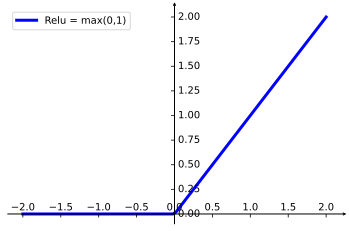

In [1]:
# Relu

import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist as axisartist

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def Relu():
    x = np.linspace(-2,2,100)
    y = [max(0,i) for i in x]
    fig = plt.figure(figsize=(6, 4))
    ax = axisartist.Subplot(fig, 111)  
    fig.add_axes(ax)
    ax.axis[:].set_visible(False)
    ax.axis["x"] = ax.new_floating_axis(0,0)
    ax.axis["x"].set_axisline_style("->", size = 0.5)
    ax.axis["y"] = ax.new_floating_axis(1,0)
    ax.axis["y"].set_axisline_style("-|>", size = 0.5)
    ax.axis["x"].set_axis_direction("top")
    ax.axis["y"].set_axis_direction("right")
    plt.plot(x,y,c = 'blue',linewidth=3,label = 'Relu = max(0,1)')
    plt.legend()
Relu()

#### 解决：引入激活函数

## 激活函数

$Relu(x) = max(0,x)$

## 非线性组合

$H1=Relu(XW_1+b_1)\space$ $H2=Relu(XW_2+b_2)\space$ $H3=f(XW_3+b_3)$

$pred = ^{\sigma}W_3 * \{^{\sigma}W_2[^{\sigma}W_1X+b_1]+b_2\}+b_3$

## 梯度下降

$objective = \sum{(pred - Y)}^2$

----

# 手写数字实战步骤：

## 1.加载图片

## 2.建立模型

## 3.训练

## 4.预测

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
import torchvision

In [3]:
# 辅助函数

def plot_curve(data):
    fig = plt.figure()
    plt.plot(range(len(data)),data,color = 'blue')
    plt.legend(['loss'],loc = 'upper right')
    plt.xlabel('step')
    plt.ylabel('loss')
    
def plot_image(img,label,name):
    fig = plt.figure()
    for i in range(6):
        plt.subplot(2,3,i + 1)
        plt.tight_layout()
        plt.imshow(img[i][0] * 0.3081 + 0.1307,cmap = 'gray',interpolation = 'none')
        plt.title('{}:{}'.format(name,label[i].item()))
        plt.xticks([])
        plt.yticks([])
        
def one_hot(label, depth=10):
    out = torch.zeros(label.size(0), depth)
    idx = torch.LongTensor(label).view(-1, 1)
    out.scatter_(dim=1, index=idx, value=1)
    return out

In [4]:
# Step1.
# 加载数据

batch_size = 64
train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('datasets/mnist_data',
                train=True,
                download=True,
                transform=torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),                       # 数据类型转化
                torchvision.transforms.Normalize((0.1307, ), (0.3081, )) # 数据归一化处理
    ])), batch_size=batch_size,shuffle=True)

test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('datasets/mnist_data/',
                train=False,
                download=True,
                transform=torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307, ), (0.3081, ))
    ])),batch_size=batch_size,shuffle=False)

Extracting datasets/mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to datasets/mnist_data/MNIST/raw


Extracting datasets/mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/mnist_data/MNIST/raw


Extracting datasets/mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/mnist_data/MNIST/raw


Extracting datasets/mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/mnist_data/MNIST/raw
Processing...
Done!




../torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [5]:
x,y = next(iter(train_loader))
print(x.shape,y.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


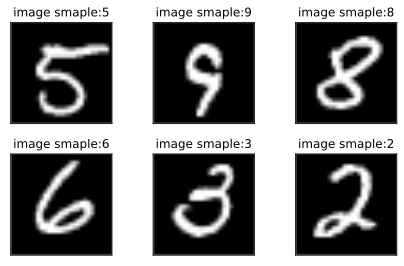

In [6]:
plot_image(x,y,'image smaple')

In [7]:
# Step2.
# 构建网络

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(28*28,256)
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,10)
    
    def forward(self,x):
        # img : [batch,1,28,28]
        # x : [batch,784]
        # h1 = relu(xw1 + b1)
        x = F.relu(self.fc1(x))
        # h2 = relu(h1w2 + b2)
        x = F.relu(self.fc2(x))
        # h3 = h2w3 + b3
        x = self.fc3(x)
        
        return x

In [8]:
# step3.
# 训练训练样本

net = Net()

# [w1,b1,w2,b2,w3,b3]
optimizer = optim.SGD(net.parameters(),lr = 0.01,momentum = 0.9)

train_loss = []
for epoch in range(3):
    for batch_idx,(x,y) in enumerate(train_loader):
        # x : [batch,1,28,28] y:[batch]
        # flatten [batch,1,28,28] - > [batch,feature]
        # x : [batch,784]
        x = x.view(x.size(0),28*28)
        out = net(x)
        
        # one-hot
        y_onehot = one_hot(y)
        
        # loss : mse(out,y_onehot)
        loss = F.mse_loss(out,y_onehot)
        
        # 清零梯度
        optimizer.zero_grad()
        
        # 计算梯度
        loss.backward()
        
        # 更新梯度
        # w' = w - lr * grad
        optimizer.step()
        
        train_loss.append(loss.item())
        
        if batch_idx % 10 == 0:
            print(f"epoch:{epoch} step:{batch_idx} loss:{loss.item()}")

epoch:0 step:0 loss:0.11937365680932999
epoch:0 step:10 loss:0.09708311408758163
epoch:0 step:20 loss:0.08858144283294678
epoch:0 step:30 loss:0.07994113117456436
epoch:0 step:40 loss:0.07734393328428268
epoch:0 step:50 loss:0.07472269237041473
epoch:0 step:60 loss:0.06988349556922913
epoch:0 step:70 loss:0.06699834764003754
epoch:0 step:80 loss:0.06196272373199463
epoch:0 step:90 loss:0.06323424726724625
epoch:0 step:100 loss:0.05360826104879379
epoch:0 step:110 loss:0.055663056671619415
epoch:0 step:120 loss:0.054498713463544846
epoch:0 step:130 loss:0.04924194887280464
epoch:0 step:140 loss:0.0507931187748909
epoch:0 step:150 loss:0.04668576270341873
epoch:0 step:160 loss:0.04542575031518936
epoch:0 step:170 loss:0.04656491428613663
epoch:0 step:180 loss:0.03774917870759964
epoch:0 step:190 loss:0.038326773792505264
epoch:0 step:200 loss:0.047219909727573395
epoch:0 step:210 loss:0.03601673245429993
epoch:0 step:220 loss:0.04262435436248779
epoch:0 step:230 loss:0.03379672393202782


epoch:2 step:60 loss:0.014353163540363312
epoch:2 step:70 loss:0.013676444068551064
epoch:2 step:80 loss:0.015563977882266045
epoch:2 step:90 loss:0.0169866681098938
epoch:2 step:100 loss:0.016173547133803368
epoch:2 step:110 loss:0.011274983175098896
epoch:2 step:120 loss:0.01801852323114872
epoch:2 step:130 loss:0.012752316892147064
epoch:2 step:140 loss:0.015997502952814102
epoch:2 step:150 loss:0.014002474024891853
epoch:2 step:160 loss:0.015389475040137768
epoch:2 step:170 loss:0.01573178544640541
epoch:2 step:180 loss:0.01387716829776764
epoch:2 step:190 loss:0.015620646066963673
epoch:2 step:200 loss:0.015027333982288837
epoch:2 step:210 loss:0.011973300948739052
epoch:2 step:220 loss:0.010340414941310883
epoch:2 step:230 loss:0.021628832444548607
epoch:2 step:240 loss:0.013886421918869019
epoch:2 step:250 loss:0.021178152412176132
epoch:2 step:260 loss:0.013787984848022461
epoch:2 step:270 loss:0.01696140132844448
epoch:2 step:280 loss:0.01277671754360199
epoch:2 step:290 loss:

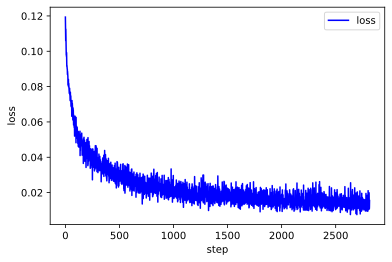

In [9]:
plot_curve(train_loss)

In [10]:
# Step4.
# 测试集验证

total_correct = 0
for x,y in test_loader:
    x =  x.view(x.size(0),28*28)
    out = net(x)
    # out : [batch,10] - > pred : [batch]
    y_pred = out.argmax(dim=1)
    correct = y_pred.eq(y).sum().float().item()
    total_correct += correct
total_num = len(test_loader.dataset)
print(f"accuracy : {total_correct/total_num}")

accuracy : 0.9516


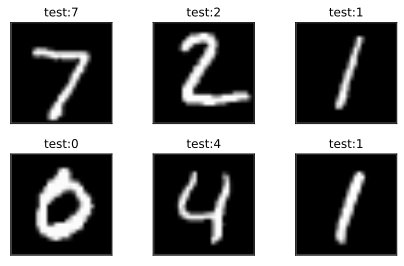

In [11]:
x,y = next(iter(test_loader))
out = net(x.view(x.size(0),28*28))
pred = out.argmax(dim=1)
plot_image(x,pred,'test')